In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

/home/hyunsu/anaconda3/envs/th1p12/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # add dimenstion of feature for torch module
t_u = torch.tensor(t_u).unsqueeze(1) 

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([7, 4, 6, 0, 1, 8, 2, 5, 9]), tensor([ 3, 10]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # linear_model is instance of nn.Linear()
# Linear's arg is input features and output features. in this case, both of them are temperature(F and C) 
linear_model(t_un_val) # there's two obervation input, thus two output(predicted by model)

tensor([[0.2597],
        [0.1552]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight, linear_model.bias # only one W and B

(Parameter containing:
 tensor([[0.0774]], requires_grad=True),
 Parameter containing:
 tensor([-0.3744], requires_grad=True))

In [7]:
x = torch.ones(1) # pytorch automatically dealt the unusual input dimension
linear_model(x)

tensor([-0.2970], grad_fn=<AddBackward0>)

In [8]:
x = torch.ones(10, 1) # there's ten samples containing one feature. Usually 0 index is the sample number of single batch.
linear_model(x)

tensor([[-0.2970],
        [-0.2970],
        [-0.2970],
        [-0.2970],
        [-0.2970],
        [-0.2970],
        [-0.2970],
        [-0.2970],
        [-0.2970],
        [-0.2970]], grad_fn=<AddmmBackward0>)

In [9]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [10]:
linear_model.parameters(), list(linear_model.parameters()) # call as list 

(<generator object Module.parameters at 0x7f301bdd2270>,
 [Parameter containing:
  tensor([[0.4468]], requires_grad=True),
  Parameter containing:
  tensor([0.7087], requires_grad=True)])

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad() # optimizer already know what params needs to be updated
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [12]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 60.3070, Validation loss 467.7675
Epoch 1000, Training loss 3.7563, Validation loss 33.0573
Epoch 2000, Training loss 2.5578, Validation loss 16.7152
Epoch 3000, Training loss 2.4676, Validation loss 13.2133

Parameter containing:
tensor([[4.7194]], requires_grad=True)
Parameter containing:
tensor([-14.5874], requires_grad=True)


In [13]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # here you can input ready-made loss function of torch or custome loss function
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 33.9044, Validation loss 307.1049
Epoch 1000, Training loss 3.6116, Validation loss 31.5591
Epoch 2000, Training loss 2.5469, Validation loss 16.4225
Epoch 3000, Training loss 2.4668, Validation loss 13.1420

Parameter containing:
tensor([[4.7232]], requires_grad=True)
Parameter containing:
tensor([-14.6063], requires_grad=True)


In [14]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [15]:
[param.shape for param in seq_model.parameters()] # W and B in each layer

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [16]:
for name, param in seq_model.named_parameters():
    print(name, param.shape) # you can call the name of params, 

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [17]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([ # Ordered Dictionary is differ from Dictionary of python. 
    ('hidden_linear', nn.Linear(1, 8)), # ordinary dictionary of python has no order. 
    ('hidden_activation', nn.Tanh()), # you can define the name of each layer using OrderedDict function.
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape) # you can check the name you typed in.

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [19]:
seq_model.output_linear.bias # you can load the parameter using named layer.

Parameter containing:
tensor([-0.0117], requires_grad=True)

In [26]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
#print('hidden', seq_model.hidden_linear.weight)
print('hidden grad', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 2.2037, Validation loss 20.2733
Epoch 1000, Training loss 2.1974, Validation loss 19.8275
Epoch 2000, Training loss 2.1912, Validation loss 19.4424
Epoch 3000, Training loss 2.1851, Validation loss 19.1257
Epoch 4000, Training loss 2.1790, Validation loss 18.8767
Epoch 5000, Training loss 2.1730, Validation loss 18.6877
output tensor([[22.5186],
        [18.2927]], grad_fn=<AddmmBackward0>)
answer tensor([[28.],
        [21.]])
hidden grad tensor([[-6.7030e-03],
        [-5.2069e-03],
        [ 5.4441e-05],
        [-1.6478e-02],
        [ 1.9542e-03],
        [-1.3178e-02],
        [ 1.8403e-03],
        [ 2.2997e-03],
        [ 3.2499e-02],
        [ 1.8331e-03],
        [ 9.5691e-03],
        [-2.3881e-03],
        [-4.7350e-04],
        [-2.3827e-03],
        [-1.8125e-03],
        [ 5.1836e-03],
        [ 9.3169e-04],
        [-7.3289e-03],
        [-5.6398e-04],
        [ 1.6367e-03]])


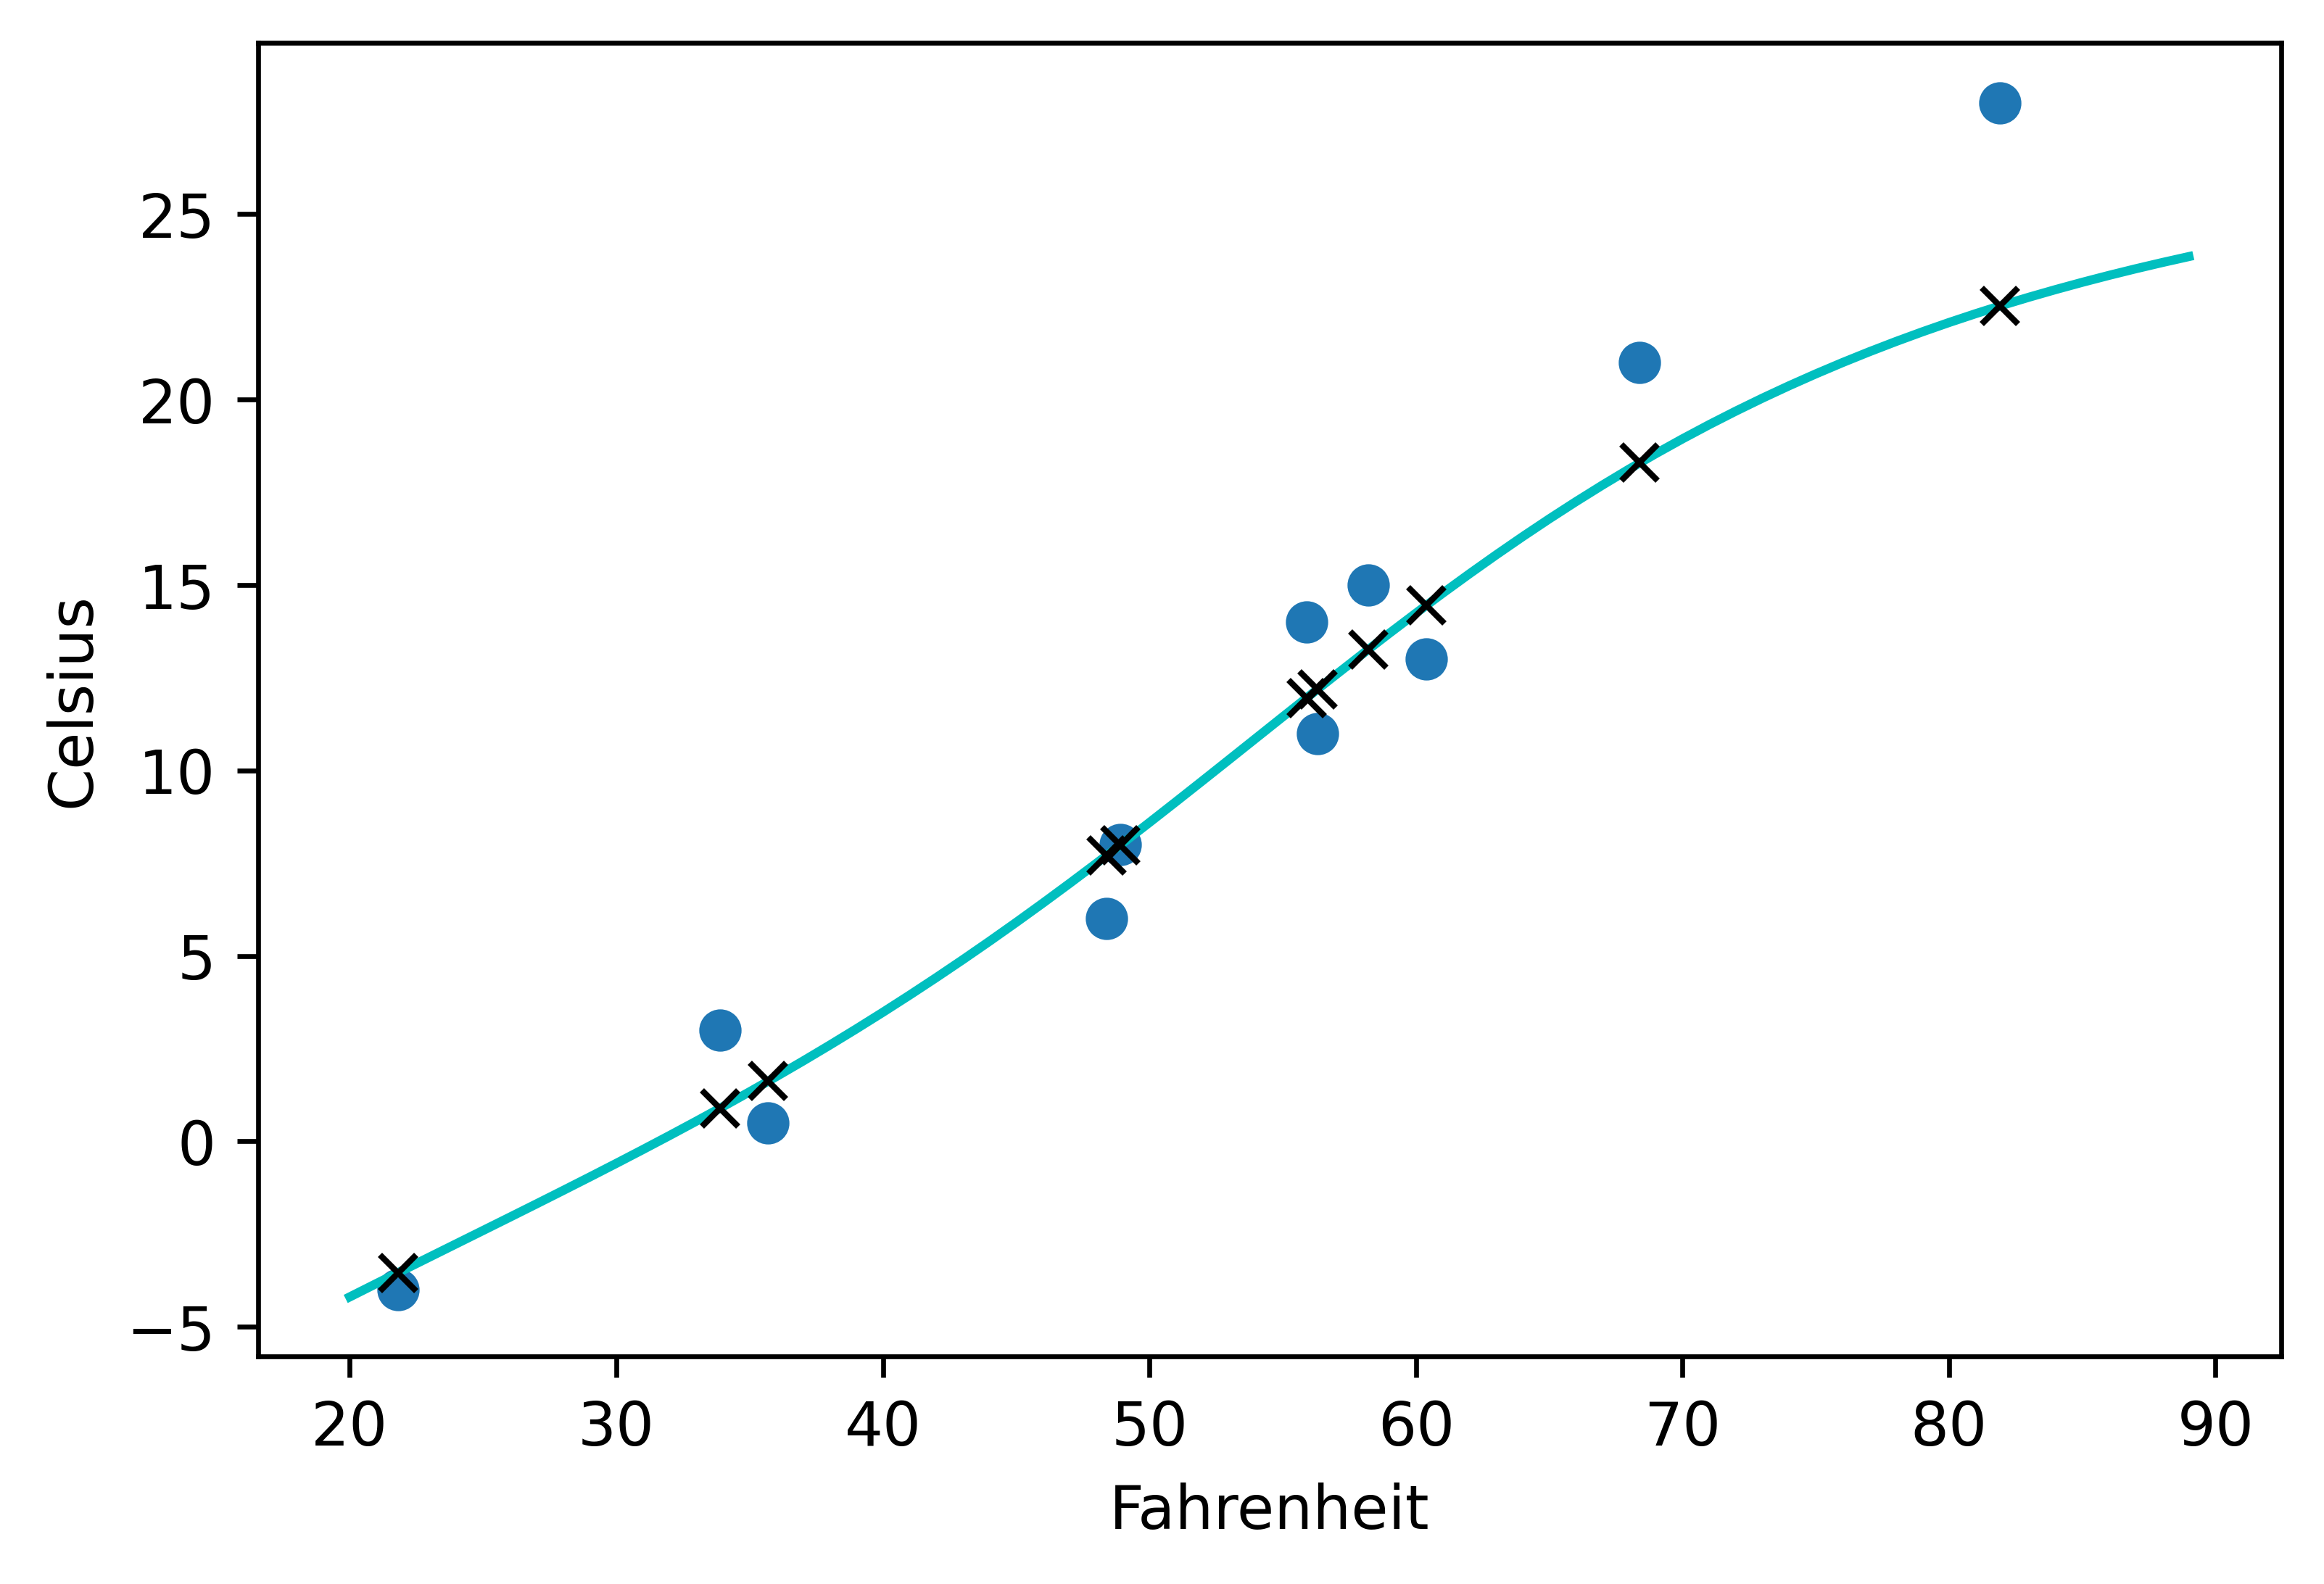

In [27]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 93.4958, Validation loss 613.1141
Epoch 1000, Training loss 29.6333, Validation loss 273.6437
Epoch 2000, Training loss 24.3124, Validation loss 237.2630
Epoch 3000, Training loss 18.5334, Validation loss 205.3222
Epoch 4000, Training loss 13.5089, Validation loss 175.0846
Epoch 5000, Training loss 9.3949, Validation loss 148.2487


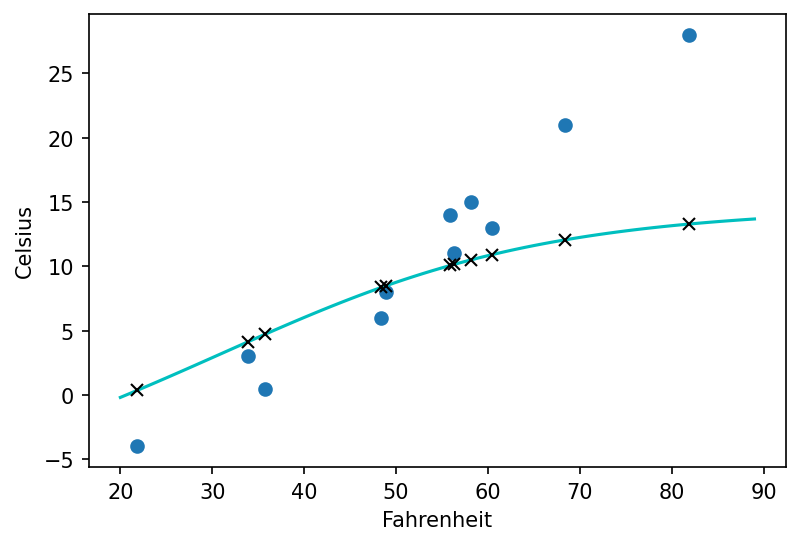

In [22]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
